In [7]:
from kernel_est_funcs import *
import numpy as np

In [8]:
spikes = np.load("spikes-10e4-ms.npy")

In [9]:
#tau = 100 #ms
#calcium_signal = sim_calcium(spikes, tau)
savgol_win_len =51

methods = ['pure_fit', 'iqr_outlier', 'ransac_outlier', 'zscore_outlier']
tau_sim = np.array([10, 20, 50, 100, 200, 300, 500, 800, 1000, 
                    1500, 2000, 3000, 5000, 8000, 10000])

tau_est_pure_fit = np.zeros(tau_sim.size)
tau_est_iqr_outlier = np.zeros(tau_sim.size)
tau_est_ransac_outlier = np.zeros(tau_sim.size)
tau_est_zscore_outlier = np.zeros(tau_sim.size)
tau_est_iqr_ransac = np.zeros(tau_sim.size)

for names in methods:
    method = globals()[names]
    counter = 0
    for i in tau_sim:
        calcium_signal = sim_calcium(spikes, i)
        signal, deriv = smoothed_signals(calcium_signal, savgol_win_len)
        var_name = 'tau_est_'+names
        globals()[var_name][counter] = -1/method(signal, deriv)
        counter +=1

next 2 blocks are for combination of iqr and ransac

In [15]:
def iqr_outlier_output(signal, deriv, threshold=1.5):
    
    x = np.array(signal)
    y = np.array(deriv)

    residuals = y - np.polyval(np.polyfit(x, y, 1), x)
    quartile_1, quartile_3 = np.percentile(residuals, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (threshold * iqr)
    upper_bound = quartile_3 + (threshold * iqr)
    mask = (residuals >= lower_bound) & (residuals <= upper_bound)

    inlier_x = x[mask]
    inlier_y = y[mask]

    return inlier_x, inlier_y

In [16]:
counter = 0
for i in tau_sim:
        calcium_signal = sim_calcium(spikes, i)
        signal, deriv = smoothed_signals(calcium_signal, savgol_win_len)
        x_iqr, y_iqr = iqr_outlier_output(signal, deriv)
        tau_est_iqr_ransac[counter] = ransac_outlier(x_iqr, y_iqr)
        counter +=1

Plotting comarison of outlier removal methods

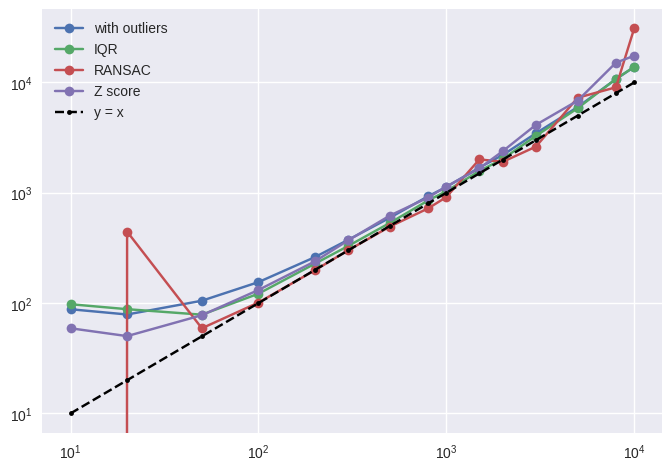

In [10]:
#%matplotlib qt
fig, ax = plt.subplots()

ax.plot(tau_sim, tau_est_pure_fit, 'o-', label='with outliers')
ax.plot(tau_sim, tau_est_iqr_outlier, 'o-', label='IQR')
ax.plot(tau_sim, tau_est_ransac_outlier, 'o-', label= 'RANSAC')
ax.plot(tau_sim, tau_est_zscore_outlier, 'o-', label='Z score')
#ax.plot(tau_sim, tau_est_iqr_ransac, 'o-', label='IQR-RASNAC')
ax.plot(tau_sim, tau_sim, '.--', color='black', label='y = x')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [11]:
abs(tau_sim - tau_est_pure_fit)/tau_est_pure_fit

array([0.88634498, 0.74637938, 0.52430767, 0.35457857, 0.23459149,
       0.19818231, 0.15731534, 0.13955265, 0.11443045, 0.11345638,
       0.0927699 , 0.13394683, 0.16448727, 0.25419359, 0.27665107])

Text(0, 0.5, 'relative error of estimated time constant')

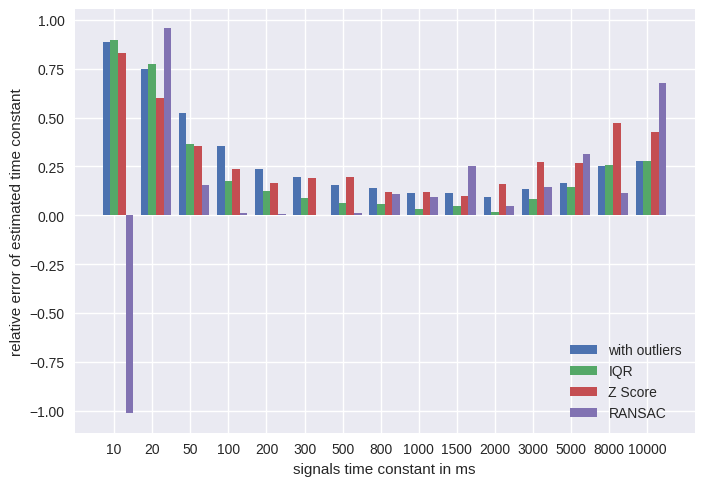

In [12]:
x = np.arange(len(tau_sim))
y1 = abs(tau_sim - tau_est_pure_fit)/tau_est_pure_fit
y2 = abs(tau_sim - tau_est_iqr_outlier)/tau_est_iqr_outlier
y3 = abs(tau_sim - tau_est_zscore_outlier)/tau_est_zscore_outlier
y4 = abs(tau_sim - tau_est_ransac_outlier)/tau_est_ransac_outlier
#y5 = abs(tau_sim - tau_est_iqr_ransac)
bar_width = 0.2
tau_sim_str = tau_sim.astype(str)

fig2, ax2 = plt.subplots()

ax2.bar(x-bar_width, y1, width=bar_width, label='with outliers')
ax2.bar(x, y2, width=bar_width, label='IQR')
ax2.bar(x+bar_width, y3, width=bar_width, label='Z Score')
ax2.bar(x+2*bar_width, y4, width=bar_width, label='RANSAC')
#ax2.bar(x+3*bar_width, y5, width=bar_width)
ax2.set_xticks(x, tau_sim_str)
#ax2.set_yscale('log')
ax2.legend()
ax2.set_xlabel('signals time constant in ms')
ax2.set_ylabel('relative error of estimated time constant')

Text(0, 0.5, 'relative error of estimated time constant')

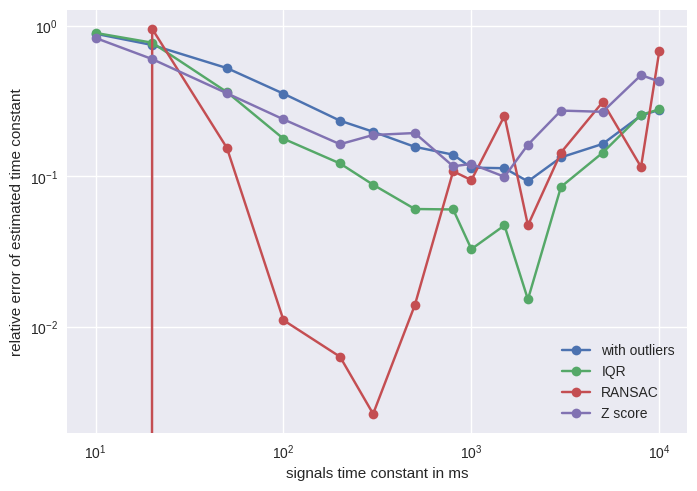

In [13]:
fig, ax = plt.subplots()

ax.plot(tau_sim, y1, 'o-', label='with outliers')
ax.plot(tau_sim, y2, 'o-', label='IQR')
ax.plot(tau_sim, y4, 'o-', label= 'RANSAC')
ax.plot(tau_sim, y3, 'o-', label='Z score')
#ax.plot(tau_sim, tau_est_iqr_ransac, 'o-', label='IQR-RASNAC')
#ax.plot(tau_sim, tau_sim, '.--', color='black', label='y = x')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('signals time constant in ms')
ax.set_ylabel('relative error of estimated time constant')

Plot of outliers

In [8]:
cal = sim_calcium(spikes)
win_len = 51
signal, deriv = smoothed_signals(cal, win_len)

In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def fit_straight_line_to_bulk(x, y, threshold=2.5):
    # Calculate Z-scores for each data point
    z_scores = np.abs(stats.zscore(y))

    # Set a threshold to identify outlier-like points
    is_outlier = z_scores > threshold

    # Exclude the outlier-like points
    x_bulk = x[~is_outlier]
    y_bulk = y[~is_outlier]

    # Perform linear regression on the remaining points
    slope, intercept, r_value, _, _ = stats.linregress(x_bulk, y_bulk)

    # Calculate the fitted values
    fitted_values = slope * x + intercept

    return fitted_values, slope, intercept

In [10]:
%matplotlib qt
scatter_all(cal, win_len)

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


In [11]:
cal = sim_calcium(spikes)
win_len =51
signal, deriv = smoothed_signals(cal, 51)
pure_fit(signal, deriv, True)

-0.006478818242032879

In [12]:
10000/66

151.5151515151515

In [13]:
iqr_outlier(signal, deriv, do_plot=True)

-0.008197597998003285

In [13]:
10000/15

666.6666666666666

In [14]:
ransac_outlier(signal, deriv, do_plot=True)

-0.006655003687623037

In [17]:
10000/92

108.69565217391305

-0.007689897336944152

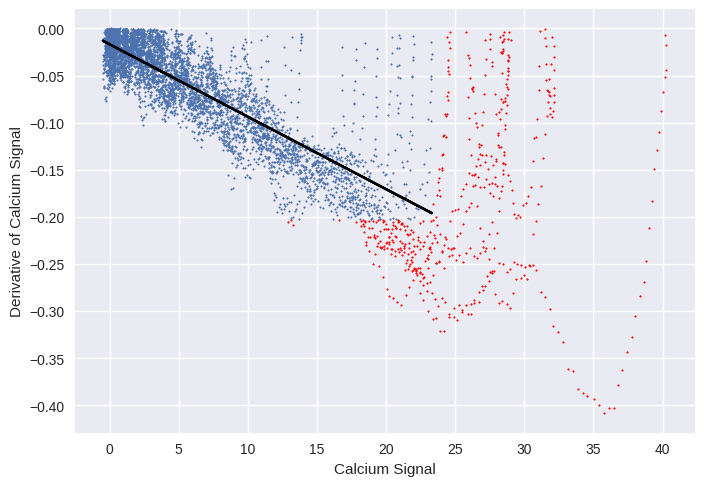

In [18]:
zscore_outlier(signal, deriv, do_plot=True)

In [19]:
10000/76

131.57894736842104